### Predicting MSFT Stock Price Inefficiencies

It would be easier to know whether or not you should buy MSFT stock options if it was possible to predict if MSFT is *undervalued*, *overvalued*, *efficient* or *volatile*, specifically:

Undervalued, if at a given time if before the end of the following week it sustains a price 3% higher for at least 2 days 

Overvalued, if at a given time if before the end of the following week it sustains a price 3% lower for at least 2 days  

Efficient, if it's not undervalued or overvalued

Volatile, if it's undervalued and overvalued

This information would be helpful for option trading strategies because contracts are priced as premiums above a strike price and so if it can be deduced that the strike price plus the premium is still less than what the price is assessed to be at, the value of the contract can be predicted to be undervalued and so purchased and hopefully realized profitably. 

**Requirements**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gmean
from math import sqrt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

**Reading in the Features**

The data folder contains a file MSFT.csv with timeseries MSFT stock market trading data.

In [18]:
df0 = pd.read_csv('../data/alpha/MSFT.csv', 
                 parse_dates=['time'], 
                 index_col='time')

# number of records in original range
n_original = len(df0[(df0.index > '2021-1-1')&(df0.index< '2022-7-1')])
print()
print('records in original range', n_original)
print('minutes in a year and a half', 60*24*365*1.5)
print()
print(df0.head(3))
print()



records in original range 231171
minutes in a year and a half 788400.0

                     Unnamed: 0    open    high     low   close  volume
time                                                                   
2022-10-20 20:00:00           0  235.40  235.40  234.75  234.75    1926
2022-10-20 19:56:00           1  234.75  234.80  234.75  234.80    3119
2022-10-20 19:55:00           2  234.75  234.75  234.75  234.75    1109



**Downsampling**

As seen above the index has gaps, only about 30% is filled. The frequency rate can be changed to adjust this. The frequency can be optimized by maximizing frequency rate while minimizing NaN rate. 

This is done by calculating the distance from the point 0,0 on the frequency-nan rate axis, which represents the maximal resolution sample with no missing values. 

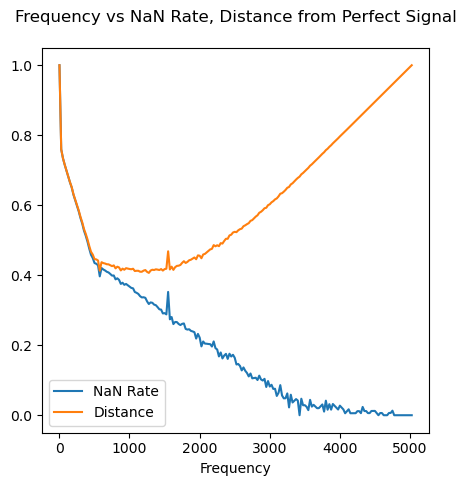

In [19]:
column_funcs = {'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'}

# print(df.head())

def na_rate(df):
    return df['high'].isnull().sum()/len(df)

freqs_vals = [1 + i for i in range(5040)][::25]
freqs = [str(freq_val) + "T" for freq_val in freqs_vals]
freqs_labels = [str(i) + "T" for i in range(5040)][::25]

na_rates = [na_rate(df0.resample(freq).agg(column_funcs))
          for freq in freqs]

df1 = pd.DataFrame(data=zip(freqs_vals, na_rates),
                   columns=['Frequency', 'NaN Rate'])

f_max = max(freqs_vals)
r_max = max(na_rates)

df1['norm_freq'] = [f/f_max for f in freqs_vals]
df1['NaN Rate'] = [r/r_max for r in na_rates]
df1['Distance'] = np.linalg.norm(df1[['norm_freq','NaN Rate']], axis=1)

plt.figure(figsize=[5,5])
ax= plt.subplot(111)
df1.plot(x='Frequency', y='NaN Rate', ax=ax)
df1.plot(x='Frequency', y='Distance', title='Frequency vs NaN Rate, Distance from Perfect Signal\n', ax=ax)
plt.savefig('../figures/freq_nan_distance.png')
plt.show()



The optimum frequency is printed and the dataset is resampled accordingly.

In [29]:
print('Optimum Frequency', df1['Frequency'].iloc[np.argmin(df1['Distance'])])
# freqq = '127T'
freqq = str(df1['Frequency'].iloc[np.argmin(df1['Distance'])]) + 'T'
df = df0.resample(freqq).agg(column_funcs)

n_resampled = len(df[(df.index > '2021-1-1')&(df.index< '2022-7-1')])
print()
print('records in new range', n_resampled)
print('days in a year and a half', int(365.25*1.5))
print()
print(df.head(5))
print()



Optimum Frequency 1276

records in new range 616
days in a year and a half 547

                           open        high         low       close    volume
time                                                                         
2020-11-02 00:00:00  200.141658  201.743185  196.624196  200.013929  27717738
2020-11-02 21:16:00  200.505195  204.484447  198.982271  203.826151  24851715
2020-11-03 18:32:00  203.816326  214.506268  202.401481  213.022646  33883080
2020-11-04 15:48:00  213.032471  220.087047  212.099066  219.133991  24326621
2020-11-05 13:04:00  219.143817  220.204951  214.221334  216.343602  18922103



**Visualizing the Features**

Each record contains the time, high, low, open, close, and volume for the *1 minute* period, where:

Time is the period's start time

High is the period's highest traded stock price

Low is the period's lowest traded stock price

Open is the period's first traded stock price

Close is the period's last traded stock price 

Volume is how many shares were traded

These can be well visualized with a candlestick chart
which uses color green and red to denote whether the price went up or down from the open to the close:

In [30]:
def candlesticks(df, volume=False):

    plt.figure(figsize=[7,7])
    # print(freqq)
    width = .8/(1400/int(freqq[:-1]))
    width2 = width/6.2

    up = df[df['close'] >= df['open']]
    down = df[df['close'] < df['open']]

    up_color = 'green'
    down_color = 'red'

    plt.bar(up.index, up.close - up.open, width, bottom = up.open, color=up_color)
    plt.bar(up.index, up.high - up.close, width2, bottom = up.close, color=up_color)
    plt.bar(up.index, up.open - up.low, width2, bottom = up.low, color=up_color)
    
    plt.bar(down.index, down.open - down.close, width, bottom = down.close, color=down_color)
    plt.bar(down.index, down.high - down.open, width2, bottom = down.open, color=down_color)
    plt.bar(down.index, down.close - down.low, width2, bottom = down.low, color=down_color)

    plt.xticks(rotation=45, ha='right')
    plt.ylim(min(df['low'][df.low > 0]) - .2*(max(df['high'][df.high > 0]) - min(df['low'][df.low > 0])),
            max(df['high'][df.high > 0] + .1*(max(df['high'][df.high > 0]) - min(df['low'][df.low > 0]))))
    
    if volume == True:
        plt.twinx()
        plt.bar(up.index, up.volume, width*.8, color=up_color)
        plt.bar(down.index, down.volume, width*.8, color=down_color)
        plt.ylim(0, max(df['volume'])*10)
        plt.tick_params(right= False, labelright=False)

    return
# candlesticks(df[df.open.notnull()][-50:], volume=True)


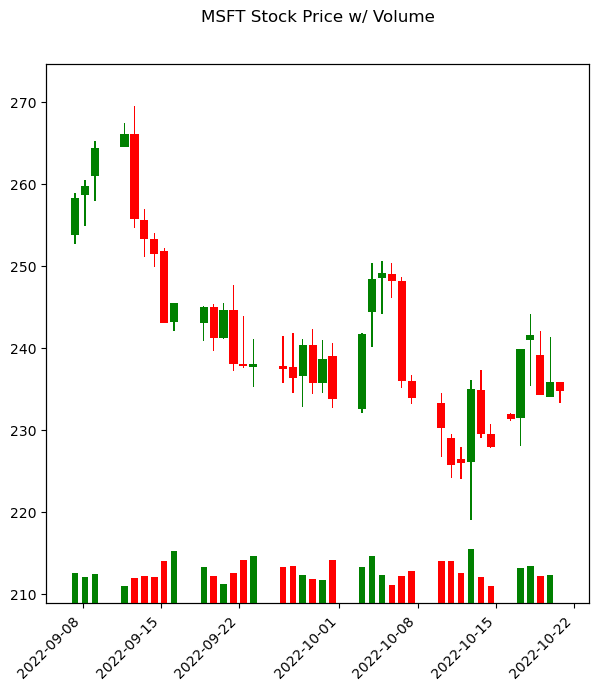

In [31]:
candlesticks(df[-50:], volume=True)

plt.title('MSFT Stock Price w/ Volume\n\n')
plt.savefig('../figures/candlesticks.png')
plt.show()


**Calculating Inefficiencies**

The following function determines if a data point is undervalued, overvalued, efficient, or volatile, given a window period, threshold rate, and confirmation period as follows:

Within the following *window period*, does the stock sustain a price change of at least *threshold rate* for *confirmation period* long?

If it doesn't pass the thresholds it's efficient, if it passes the thresholds with a positive change it's undervalued, if it passes the thresholds with a negative change it's overvalued, and if it exceeds the thresholds in both directions it's volatile. 

In [32]:
def inefficiencies(df, window_period, threshold_rate, confirmation_window=None, round_up_week=False):

    # start = df.index
    df = df[df.open.notnull()]
    start = df.index
    if round_up_week:
        window_period = window_period + pd.Timedelta(weeks=1) - pd.Series([(i.dayofweek+1) * pd.Timedelta(days=1) for i in start])

    end = start + window_period
    ineffy = np.full(len(df),'efficient')
    horizonmax = [max(df['high'][(df.index >= s) & (df.index < e)]) for s, e in zip(start, end)]
    horizonmin = [min(df['low'][(df.index >= s) & (df.index < e)]) for s, e in zip(start, end)]
    # print(horizonmax[:5],horizonmin[:5],df.close[:5])
    # print((horizonmax/df['close'] - 1) > threshold_rate)
    underpriced = (horizonmax/df['close'] - 1) > threshold_rate
    overpriced = (horizonmin/df['close'] - 1) < -threshold_rate
    volatile = underpriced & overpriced
          

    if confirmation_window:
        end = start + confirmation_window
        underpriced = [underpriced[(df.index >= s) & (df.index < e)].all() for s, e in zip(start, end)]
        # underpriced = underpriced.rolling(window=8).apply(lambda x: x.all())
        overpriced = [overpriced[(df.index >= s) & (df.index < e)].all() for s, e in zip(start, end)]
        # overpriced = overpriced.rolling(window=8).apply(lambda x: x.all())
        volatile = [u & o for u,o in zip(underpriced, overpriced)]
        
        ineffy[underpriced] = 'underpriced'
        ineffy[overpriced] = 'overpriced'
        ineffy[volatile] = 'volatile'

    else:
    
        ineffy[underpriced] = 'underpriced'
        ineffy[overpriced] = 'overpriced'
        ineffy[volatile] = 'volatile'

    return pd.DataFrame(data=ineffy, index=df.index, columns=['inefficiency'])


In [33]:
ineffy = inefficiencies(df,
                     window_period = pd.Timedelta(weeks=1), 
                     threshold_rate =.02, 
                     confirmation_window = pd.Timedelta(days=2))['inefficiency']

#rounds up the horizon period to the following friday
ineffy2 = inefficiencies(df,
                     window_period = pd.Timedelta(weeks=1), 
                     threshold_rate =.02,
                     confirmation_window = pd.Timedelta(days=2),
                     round_up_week=True)['inefficiency'] 

print()
print('Shorter Horizon Value Counts')
print(ineffy.value_counts())
print()
print('Longer Horizon Value Counts')

df2 = df.join(ineffy2)
print(ineffy2.value_counts())
print(df2.inefficiency.isnull().sum())
print()



Shorter Horizon Value Counts
efficient    202
overprice    191
underpric    174
volatile      62
Name: inefficiency, dtype: int64

Longer Horizon Value Counts
overprice    230
underpric    208
efficient    105
volatile      86
Name: inefficiency, dtype: int64
182



A longer horizon means more datapoints being classified as undervalued, overvalued, and volatile because the longer the horizon the more chances it has to deviate from baseline.

**Visualizing Inefficiencies**

These can be visualized by changing the colors of the candlesticks plot to represent the datapoint's inefficiency class.

In [35]:
def coloredsticks(df):
    
    fig, ax = plt.subplots(figsize=[10,10])

    width = .8/(1400/int(freqq[:-1]))


    width2 = width/6.2

    underpriced = df[df['inefficiency'] == 'underpric']
    overpriced = df[df['inefficiency'] == 'overprice']
    efficient = df[df['inefficiency'] == 'efficient']
    not_null = df[df['inefficiency'] == 'efficient']['open'].notnull()
    efficient = efficient[not_null]
    volatile = df[df['inefficiency'] == 'volatile']

    plt.bar(volatile.index, volatile.close - volatile.open, width, bottom = volatile.open, color='y', label='volatile')
    plt.bar(volatile.index, volatile.high - volatile.close, width2, bottom = volatile.close, color='y')
    plt.bar(volatile.index, volatile.open - volatile.low, width2, bottom = volatile.low, color='y')

    plt.bar(underpriced.index, underpriced.close - underpriced.open, width, bottom = underpriced.open, color='c', label='undervalued')
    plt.bar(underpriced.index, underpriced.high - underpriced.close, width2, bottom = underpriced.close, color='c')
    plt.bar(underpriced.index, underpriced.open - underpriced.low, width2, bottom = underpriced.low, color='c')

    plt.bar(overpriced.index, overpriced.close - overpriced.open, width, bottom = overpriced.open, color='m', label='overvalued')
    plt.bar(overpriced.index, overpriced.high - overpriced.close, width2, bottom = overpriced.close, color='m')
    plt.bar(overpriced.index, overpriced.open - overpriced.low, width2, bottom = overpriced.low, color='m')

    plt.bar(efficient.index, efficient.close - efficient.open, width, bottom = efficient.open, color='b', label='efficient')
    plt.bar(efficient.index, efficient.high - efficient.close, width2, bottom = efficient.close, color='b')
    plt.bar(efficient.index, efficient.open - efficient.low, width2, bottom = efficient.low, color='b')

    plt.legend()
    
    ax.tick_params(axis= 'x', which='major', labelsize=12, rotation=45)
    ax.tick_params(axis= 'y', which='major', labelsize=12)
    plt.ylim(min(df['low'][df.low > 0]) - .2*(max(df['high'][df.high > 0]) - min(df['low'][df.low > 0])),
            max(df['high'][df.high > 0] + .1*(max(df['high'][df.high > 0]) - min(df['low'][df.low > 0]))))
    
    plt.twinx()
    plt.bar(efficient.index, efficient.volume, width*.8, color='b')
    plt.bar(underpriced.index, underpriced.volume, width*.8, color='c')
    plt.bar(overpriced.index, overpriced.volume, width*.8, color='m')
    plt.bar(volatile.index, volatile.volume, width*.8, color='y')
    plt.ylim(0, max(df['volume'])*10)
    plt.tick_params(right= False, labelright=False, size=21)


    return


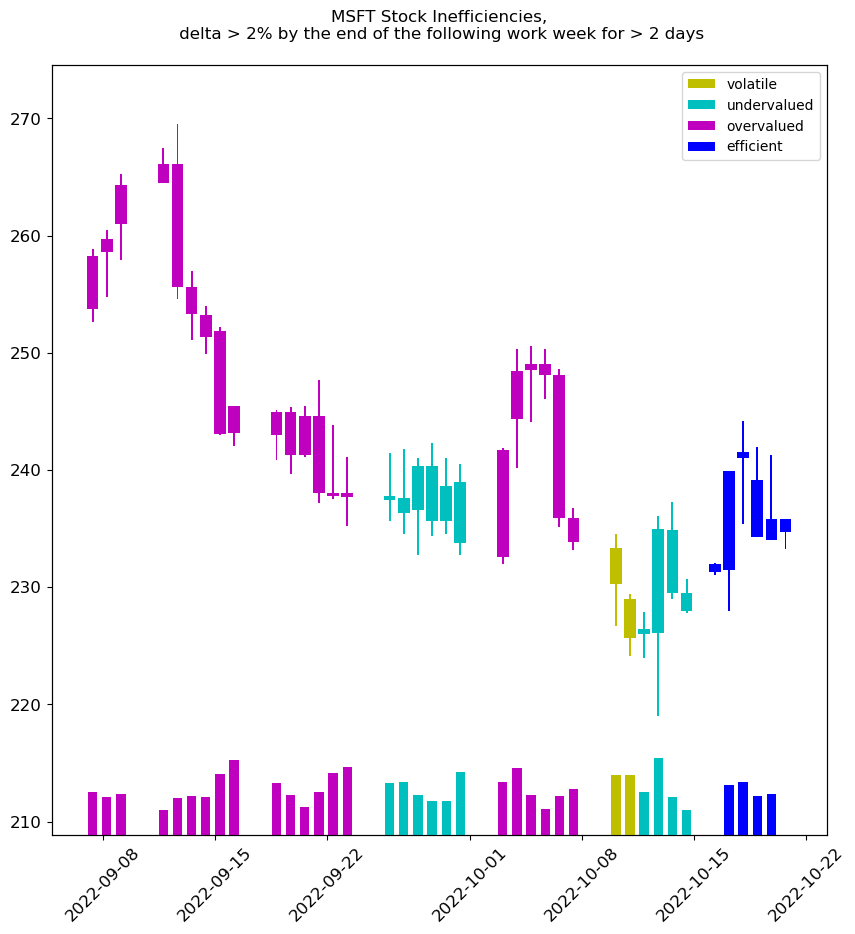

In [36]:
coloredsticks(df2[-50:])
plt.title('MSFT Stock Inefficiencies,\n delta > 2% by the end of the following work week for > 2 days\n')
plt.savefig('../figures/classsticks.png')
plt.show()


The volume frequency distribution of the diffrent classes are visualized below. 

In [27]:
def volume_by_class(df, oneplt=True, violin=False):
    
#     if violin==True:
#         classes = df.inefficiency.unique()
#         dataset = [df[df['inefficiency']==c]['volume'].apply(lambda x:np.log10(x+1))
#                   for c in classes]

#         plt.violinplot(dataset=dataset, points=100)
#         # plt.semilogy()
#         plt.xticks([1,2,3,4],['underpriced','volatile', 'efficient', 'overpriced'])
#         plt.yticks([0,1,2,3,4,5,6,7,8],['$10^0$','$10^1$','$10^2$','$10^3$','$10^4$','$10^5$','$10^6$','$10^7$','$10^8$'])


#         plt.ylabel('Volume [# of shares traded]')
#         plt.xlabel('Effiency Class')
#         # plt.ylim(4,8)
#         plt.show()
#     if oneplt==True:
#         colors = ['b', 'm', 'c', 'y']
#         classes = ['efficient', 'underpric', 'overprice', 'volatile']
#         labels = ['efficient', 'underpriced', 'overpriced', 'volatile']
#         for i,c in enumerate(classes):
#             plt.hist(df[df.inefficiency==c].volume, bins=np.logspace(2, 8, 20), alpha = .9, label=labels[i], color=colors[i])
#         plt.xlabel('Volume [# of traded shares]')
#         plt.ylabel('Frequency')
#         plt.title('Volume Frequency by Inefficiency Class')
#         plt.tight_layout()
#         plt.semilogx()
#         plt.legend()
#         plt.show()
#     else:
    fig=plt.figure(figsize=[8,5])
    gs=fig.add_gridspec(4,hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)
    colors = ['b', 'm', 'c', 'y']
    classes = ['efficient', 'underpric', 'overprice', 'volatile']
    labels = ['efficient', 'underpriced', 'overpriced', 'volatile']
    for i,c in enumerate(classes):
        class_volume = df[df.inefficiency==c].volume
        class_volume = class_volume[class_volume.notnull()]
        axs[i].hist(class_volume, bins=np.logspace(2, 8, 90),alpha = .9, label=labels[i], color=colors[i])
        axs[i].axvline(class_volume.median(), linestyle=':', color=(0,0,0), alpha=.5)
        axs[i].axvline(class_volume.mean(), linestyle=':', color=(1,1,0), alpha=1)
        # axs[i].axvline(df[df.notnull()].volume.median(), linestyle=':', color=(1,0,0), alpha=.5)
        # axs[i].axhline(len(class_volume)/90, linestyle=':', color=(1,0,0), alpha=.5)

    plt.xlabel('Volume [# of traded shares]')
    fig.text(0,.5,'Frequency\n',rotation='vertical', va='center')
    fig.text(.5,0, 'The median and mean are shown in black and yellow, respectively. The volatile class has the largest average\n mean and median volume, and the efficient class  has the smallest mean and median values.', ha='center')

    fig.suptitle('Volume Frequency by Inefficiency Class')
    fig.tight_layout(pad=3)
    plt.semilogx()
    fig.text(.25,.73,'efficient', va='center', color='b')

    fig.text(.25,.57,'overvalued', va='center', color='m')

    fig.text(.25,.41,'undervalued', va='center', color='c')

    fig.text(.25,.25,'volatile', va='center', color='y')




    return


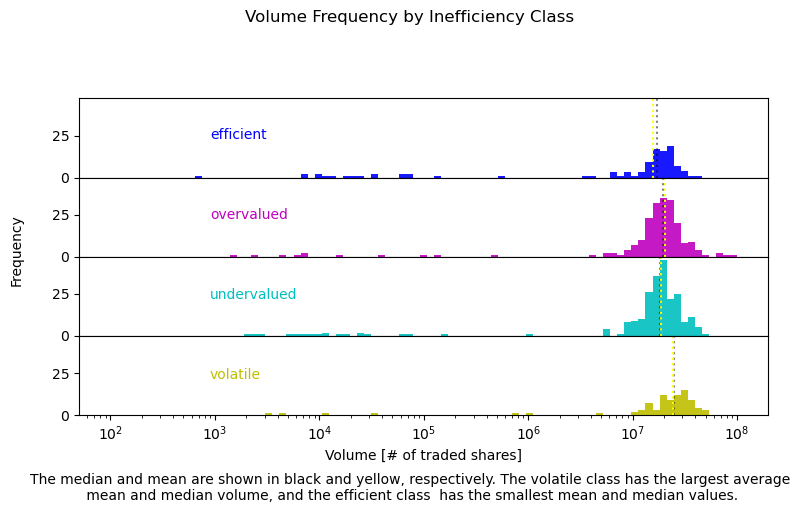

In [28]:
volume_by_class(df2, oneplt=False)
# plt.tight_layout()
plt.savefig('../figures/volume_hist_by_class.png')
plt.show()


**Splitting the Data**

2021 will serve as the training set, 2022 Q1 will be the validation set and and 2022 Q2 will be the test set. 

In [68]:
def split_time_series(df, train_rate, val_rate, test_rate):
    
    rates = [train_rate, val_rate, test_rate]
    
    for rate in rates:
        try:
            assert(type(rate) == type(1.1))
        except AssertionError:
            print('rate must be float')
    try:
        assert(sum(rates) == 1)
    except AssertionError:
        print('rates must sum to 1')
            
    train_i = int(len(df.index)*train_rate)
    test_i = train_i + int((len(df.index) - train_i)*(val_rate/(val_rate+test_rate)))
    
    train_X = df[df.columns[:-1]].iloc[:train_i]
    test_X = df[df.columns[:-1]].iloc[train_i:test_i]
    val_X = df[df.columns[:-1]].iloc[test_i:]
    
    train_y = df[df.columns[-1]].iloc[:train_i]
    test_y = df[df.columns[-1]].iloc[train_i:test_i]
    val_y = df[df.columns[-1]].iloc[test_i:]
    
    return train_X, train_y, test_X, test_y, val_X, val_y

In [69]:
# jan1 2020 - june30 2021
df3 = df2[(df2.index > '2021-1-1')&(df2.index< '2022-7-1')]


X_train, y_train, X_test, y_test, X_val, y_val = split_time_series(df3,.67, .165, .165)

sets = [X_train, y_train, X_test, y_test, X_val, y_val]

print('X train index range')
print('start', X_train.index[0])
print('stop', X_train.index[-1], '\n')


print('X test index range')
print('start', X_test.index[0])
print('stop', X_test.index[-1], '\n')


print('X val index range')
print('start', X_val.index[0])
print('stop', X_val.index[-1], '\n')


X train index range
start 2021-01-01 06:08:00
stop 2021-12-31 10:44:00 

X test index range
start 2022-01-01 08:00:00
stop 2022-03-31 19:56:00 

X val index range
start 2022-04-01 17:12:00
stop 2022-06-30 05:08:00 



**Preprocessing**

Autoregression is used to create lag features. 

In [11]:
def autoregression(df, lag):
    lag_features = [df.shift(i) for i in range(lag)]
    X = pd.concat(lag_features,axis=1)
    X.columns = [*df.columns, *[c+' lag'+str(int(i/len(df.columns))) for i,c in  enumerate(X.columns) if i >= len(df.columns)]]
    return X


X_train = autoregression(X_train,2)
X_test = autoregression(X_test,2)
X_val = autoregression(X_val,2)


print(X_train.columns)
print(len(set(X_train.columns)))
print(len(X_train.columns))

Index(['open', 'high', 'low', 'close', 'volume', 'open lag1', 'high lag1',
       'low lag1', 'close lag1', 'volume lag1'],
      dtype='object')
10
10


Differencing is used to reduce stationarity.

In [12]:
def differencing(df, lag):
    lag_features = [df - df.shift(i) for i in np.arange(1,lag+1)]
    X = pd.concat([df, *lag_features],axis=1)
    X.columns = [*df.columns, *[c+' difference'+str(int(i/len(df.columns))) for i,c in  enumerate(X.columns) if i>=len(df.columns)]]
    return X

X_train = differencing(X_train,1)
X_test = differencing(X_test,1)
X_val = differencing(X_val,1)


print(len(set(X_train.columns)))
print(len(X_train.columns))

20
20


The features are standardized.

In [13]:
std_ftrs = X_train.columns
# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 

X_train_prep = clf.fit_transform(X_train)
X_test_prep = clf.transform(X_test)
X_val_prep = clf.transform(X_val)


fix = lambda x: np.nan_to_num(x,nan=-9999)

fix(X_train_prep)

array([[-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -2.00501793e-03],
       ...,
       [ 1.78866890e+00,  1.74910072e+00,  1.82248005e+00, ...,
        -3.28781922e-01, -3.60122886e-01, -3.19753759e-02],
       [ 1.75800905e+00,  1.70255036e+00,  1.70447861e+00, ...,
         1.06306021e-01, -4.63457077e-01, -3.72511785e-01],
       [ 1.65592240e+00,  1.61290766e+00,  1.69670124e+00, ...,
        -1.41940237e+00, -1.29316984e+00,  8.16591766e-02]])

**Testing the Classifier**

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def simple_ML_pipeline(X_train,X_test,y_train,y_test):
    LR = LogisticRegression(penalty='l2', C = 1, max_iter = 10000, random_state=42) # logistic regression is a simple linear classifier
    LR.fit(X_train,y_train)
    y_test_pred = LR.predict(X_test)
    return accuracy_score(y_test, y_test_pred)
    
    
print(y_train[y_train.notnull()])
test_score = simple_ML_pipeline(fix(X_train_prep)[y_train.notnull()],fix(X_test_prep)[y_test.notnull()],y_train[y_train.notnull()],y_test[y_test.notnull()])
print('baseline', y_train.value_counts()[0]/len(y_train))
print(test_score)

time
2021-01-03 21:56:00    efficient
2021-01-04 19:12:00    efficient
2021-01-05 16:28:00    efficient
2021-01-06 13:44:00    efficient
2021-01-07 11:00:00    efficient
                         ...    
2021-12-27 21:40:00    overprice
2021-12-28 18:56:00    overprice
2021-12-29 16:12:00    overprice
2021-12-30 13:28:00    overprice
2021-12-31 10:44:00    overprice
Name: inefficiency, Length: 319, dtype: object
baseline 0.5558252427184466
0.4
